# Lung segmentation from Chest X-Ray dataset

**About the data**:
- The dataset is made up of images and segmentated mask from two diffrent sources. __(이미지랑 마스크의 출저가 각각 다름)__
- There is a slight abnormality(기형,이상) in naming convention of masks. __(마스크 파일 이름이 조금씩 다름.)__
- Some images don't have their corresponding masks. __(몇몇 이미지는 매칭되는 마스크를 가지고 있지 않음.)__
- Images from the Shenzhen dataset has apparently smaller lungs as compared to the Montgomery dataset.
- __(Shenzhen dataset은 Montgomery dataset에 비해 폐의 크기가 상대적으로 작음.)__

## Take a look at the dataset

In [2]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

## Set paths

In [3]:
image_path = os.path.join("E:\kaggle\lungs\dataset\Lung Segmentation\\CXR_png")
mask_path = os.path.join("E:\kaggle\lungs\dataset\Lung Segmentation\\","masks\\")


They can inspected the concerning dataset seperately [here](http://https://www.kaggle.com/kmader/pulmonary-chest-xray-abnormalities/home).

In [4]:
# we have 704 masks but 800 images. Hence we are going to
# make a 1-1 correspondance from mask to images, not the usual other way.

# 평소와는 다른 방법으로 mask 와 image를 1;1 매칭할 것이다.

images = os.listdir(image_path)
mask = os.listdir(mask_path)

print(images[0:3])
print(mask[0:3])

mask = [fName.split(".png")[0] for fName in mask] 
# 'CHNCXR_0001_0_mask', 'CHNCXR_0002_0_mask'   
# ".png" 를 뺀 앞부분만 출력

image_file_name = [fName.split("_mask")[0] for fName in mask] 
# 'CHNCXR_0001_0', 'CHNCXR_0002_0'

['CHNCXR_0001_0.png', 'CHNCXR_0002_0.png', 'CHNCXR_0003_0.png']
['CHNCXR_0001_0_mask.png', 'CHNCXR_0002_0_mask.png', 'CHNCXR_0003_0_mask.png']


In [5]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))
print(check[0:2])

Total mask that has modified name: 566
['CHNCXR_0001_0_mask', 'CHNCXR_0002_0_mask']


Earlier I was going to train on the Shenzhen dataset while perform prediction on the Montgomery dataset.  
(이전에는 Montgomery dataset을 예측하는동안 Shenzhen dataset을 training하려고 했었다.)  


However, the nature of the data was diffrent in both the set.   
(그러나 두 dataset이 서로 달랐다.)  


The images from Shenzhen dataset had smaller lung-to-image ratio as compared to the Montgomery dataset.  
(Shenzhen dataset이 Montgomery dataset 보다 폐-이미지 비율이 더 작다.)  


Thus, I am loading the two dataset seperately which I combined once I got to know about the disparity.  
(그래서, 두 dataset이 불일치한걸 알게되어서, 내가 결합했었던 두 dataset을 따로따로 불러올것이다.)  

In [6]:
# 집합 자료형 set 
# 교집합 &
# 참고 링크 -> https://wikidocs.net/1015

testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check 
# check -> 'CHNCXR_0001_0_mask', 'CHNCXR_0002_0_mask'

def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    if flag == "test":
        for i in tqdm(testing_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]
            
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array,mask_array
    
    if flag == "train":
        for i in tqdm(training_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

In [7]:
# perform sanity check : 이치에 맞는지(타당한지) 검토하다.

def plotMask(X,y):
    sample = []
    
    # sample로 6개만 확인할거임.
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right)) # np.hstack (두 배열을 왼쪽에서 오른쪽으로 붙이기)
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()

In [8]:
# Load training and testing data
dim = 128*2 # 원래는 512x512 이지만 OOM 때문에 256x256으로 진행
X_train, y_train = getData(dim,flag="train") # 256 x 256 size로 train data 만듬.
X_test, y_test = getData(dim) # 256 x 256 size로 test data 만듬.

100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [00:48<00:00,  2.82it/s]


# Perform Sanity Check

It is prudent(신중한) to perform sanity check of the data correspondence(일치).   
It become a routine check-up after a while but it is very crucial to check if we had made a mistake in loading the data.

__잘못 로드한 데이터가 있는지 없는지 확인하는 작업__

training set


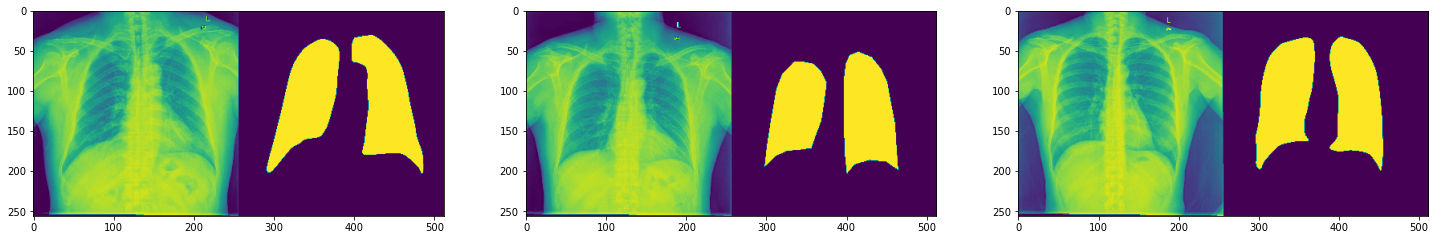

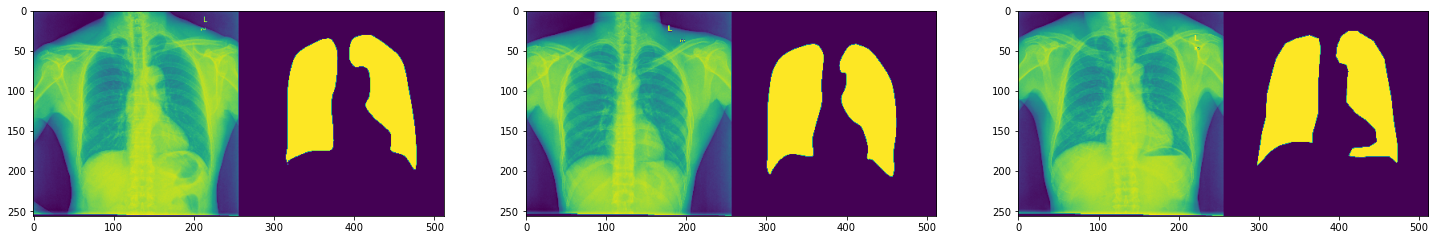

testing set


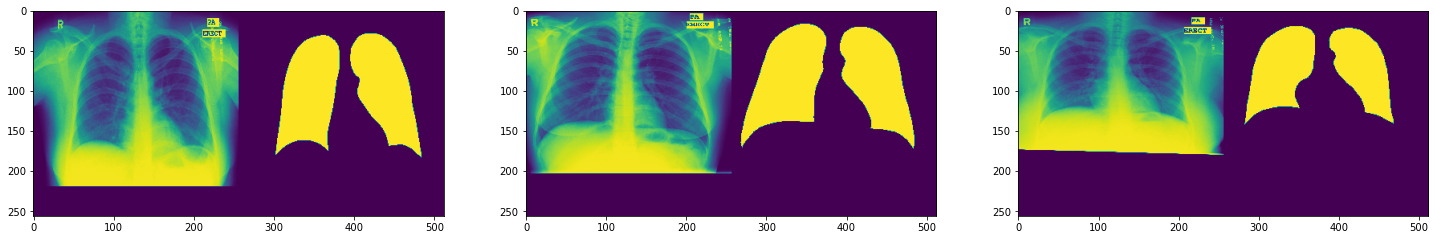

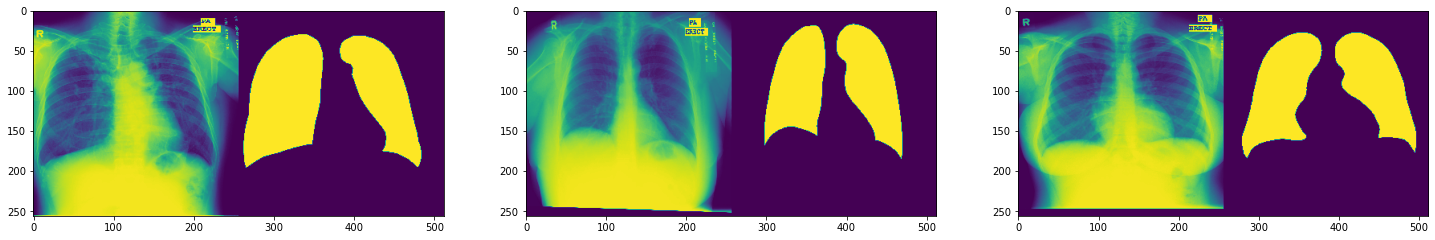

In [9]:
print("training set")
plotMask(X_train,y_train)
print("testing set")
plotMask(X_test,y_test)

Both the sets looks correct. Let's combine them and further use them as a unified(통일된) dataset.

보아하니, 두 dataset이 올바르니깐, 결합하여서 dataset으로 쓸것이다.

In [10]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1) # convolution을 위한 4차원으로 reshape & 흑백으로 처리할것이므로 1
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1) # convolution을 위한 4차원으로 reshape & 흑백으로 처리할것이므로 1
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1) # convolution을 위한 4차원으로 reshape & 흑백으로 처리할것이므로 1
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1) # convolution을 위한 4차원으로 reshape & 흑백으로 처리할것이므로 1

# 가정 설정문 assert (혹시라도 틀린 부분이 있으면 오류가 발생하게하는 조건문)

assert X_train.shape == y_train.shape # False 이면 오류가 발생함.
assert X_test.shape == y_test.shape

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

(566, 256, 256, 1)
(566, 256, 256, 1)
(138, 256, 256, 1)
(138, 256, 256, 1)


## Define  the network and callbacks

I am going to use my favourite segmentation network - U-Nets. You can read about them [here](https://arxiv.org/abs/1505.04597).

In [11]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

# image segementation 전용 오차 측정 공식 
# dice_coef_loss
# 설명 Link -> http://machinelearningkorea.com/2019/07/13/%ED%8F%89%EA%B0%80%EC%A7%80%ED%91%9C-dice/

def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

Using TensorFlow backend.


#### Compile and train the Unet Model

In [15]:
model = unet(input_size=(256,256,1)) # 512x512에서 256x256으로 바꿈 (OOM때문에)
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 256, 256, 32) 320         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 128, 128, 32) 0           conv2d_59[0][0]                  
____________________________________________________________________________________________

## Callbacks, Early Stopping and Reduced LR


In [12]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="{}\\weights.best.hdf5".format('E:\kaggle\lungs\models') # 저장경로 설정

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited

callbacks_list = [checkpoint, early, reduceLROnPlat]

C:\anaconda3\envs\tf2.0-gpu\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


#### Train the model

I intially used a 60-40 train-test spit and got a loss of -0.97. However, the better way to do it is 80-10-10 train-test-validation spit. Below I am roughly doing the later.

In [13]:
from IPython.display import clear_output
from keras.optimizers import Adam 
from sklearn.model_selection import train_test_split

model.compile(optimizer=Adam(lr=2e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy'])

# images = np.concatenate((X_train,X_test),axis=0)
# mask  = np.concatenate((y_train,y_test),axis=0)

train_vol, validation_vol, train_seg, validation_seg = train_test_split( (images-127.0)/127.0 , 
                                                            (mask>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 2018)
# 일반 폐사진 dataset을 정규화한 후 
# train_vol 90% , validaion_vol 10%로 쪼갬.

# mask 폐사진 dataset의 pixel의 값이 127이상이면 1 아니면 0으로 나타나게 한 후 
# train_seg 90% , validation_seg 10%로 쪼갬.

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 2018)


loss_history = model.fit(x = train_vol,
                        y = train_seg,
                         batch_size = 16,
                  epochs = 50,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)


# clear_output() -> 이거 넣으면 진행결과 깔끔하게 다 사라짐.

Train on 569 samples, validate on 64 samples
Epoch 1/50
569/569 [==============================] - 14s 25ms/step - loss: -0.3585 - dice_coef: 0.3597 - binary_accuracy: 0.5851 - val_loss: -0.4295 - val_dice_coef: 0.4295 - val_binary_accuracy: 0.5500

Epoch 00001: val_loss improved from inf to -0.42947, saving model to E:\kaggle\lungs\models\weights.best.hdf5
Epoch 2/50
569/569 [==============================] - 7s 12ms/step - loss: -0.6052 - dice_coef: 0.6078 - binary_accuracy: 0.7652 - val_loss: -0.7843 - val_dice_coef: 0.7843 - val_binary_accuracy: 0.8905

Epoch 00002: val_loss improved from -0.42947 to -0.78432, saving model to E:\kaggle\lungs\models\weights.best.hdf5
Epoch 3/50
569/569 [==============================] - 7s 12ms/step - loss: -0.8655 - dice_coef: 0.8658 - binary_accuracy: 0.9328 - val_loss: -0.8860 - val_dice_coef: 0.8860 - val_binary_accuracy: 0.9478

Epoch 00003: val_loss improved from -0.78432 to -0.88600, saving model to E:\kaggle\lungs\models\weights.best.hdf5
Ep


Epoch 00028: val_loss improved from -0.96148 to -0.96212, saving model to E:\kaggle\lungs\models\weights.best.hdf5
Epoch 29/50
569/569 [==============================] - 7s 12ms/step - loss: -0.9667 - dice_coef: 0.9667 - binary_accuracy: 0.9833 - val_loss: -0.9619 - val_dice_coef: 0.9619 - val_binary_accuracy: 0.9814

Epoch 00029: val_loss did not improve from -0.96212
Epoch 30/50
569/569 [==============================] - 7s 12ms/step - loss: -0.9671 - dice_coef: 0.9672 - binary_accuracy: 0.9835 - val_loss: -0.9618 - val_dice_coef: 0.9618 - val_binary_accuracy: 0.9814

Epoch 00030: val_loss did not improve from -0.96212
Epoch 31/50
569/569 [==============================] - 7s 12ms/step - loss: -0.9674 - dice_coef: 0.9674 - binary_accuracy: 0.9836 - val_loss: -0.9616 - val_dice_coef: 0.9616 - val_binary_accuracy: 0.9812

Epoch 00031: val_loss did not improve from -0.96212

Epoch 00031: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 32/50
569/569 [===========

## Plot the metric and evaluate 

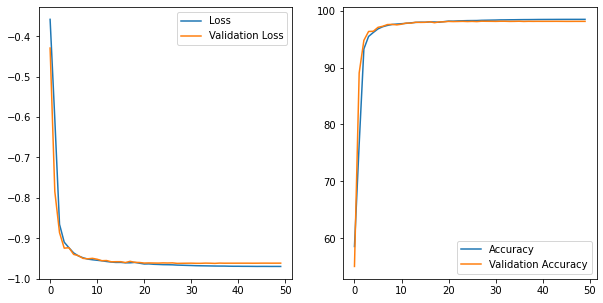

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

## Test the model

71
[57  2 21 69 56  2 38 43 43 68]



(71, 256, 256, 1)
(71, 256, 256, 1)
(71, 256, 256, 1)


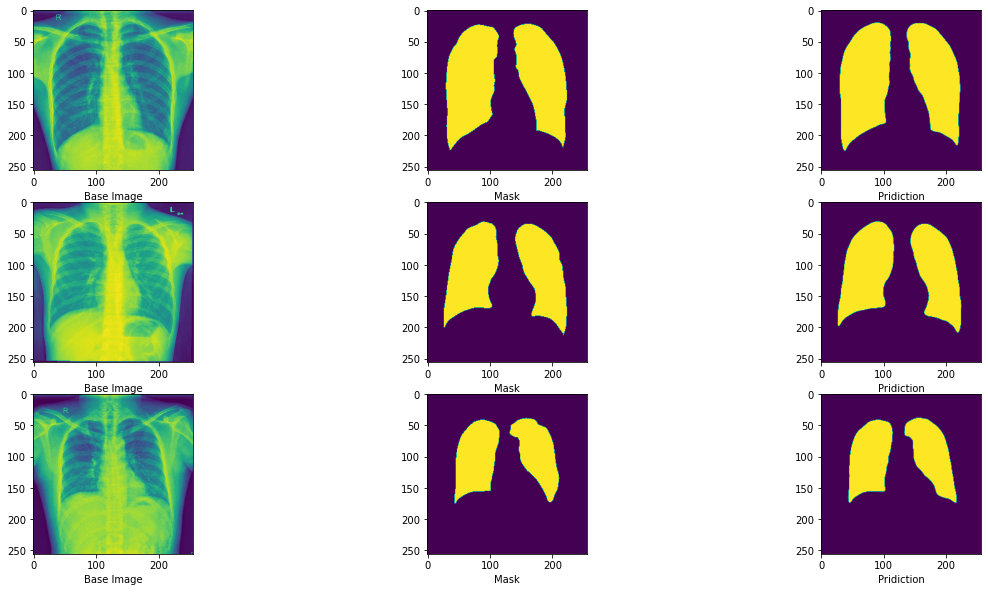

In [34]:
pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
preds = model.predict(validation_vol)

print(validation_vol.shape[0])
print(pred_candidates)
print('\n\n')

print(validation_vol.shape)
print(validation_seg.shape)
print(preds.shape)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
    plt.xlabel("Base Image") # 기본 image
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
    plt.xlabel("Mask") # Mask image

    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Pridiction") # 예측한 Mask image

71
[31 31 52 52 26 70 18 58  6 34]



(71, 256, 256, 1)
(71, 256, 256, 1)
(71, 256, 256, 1)


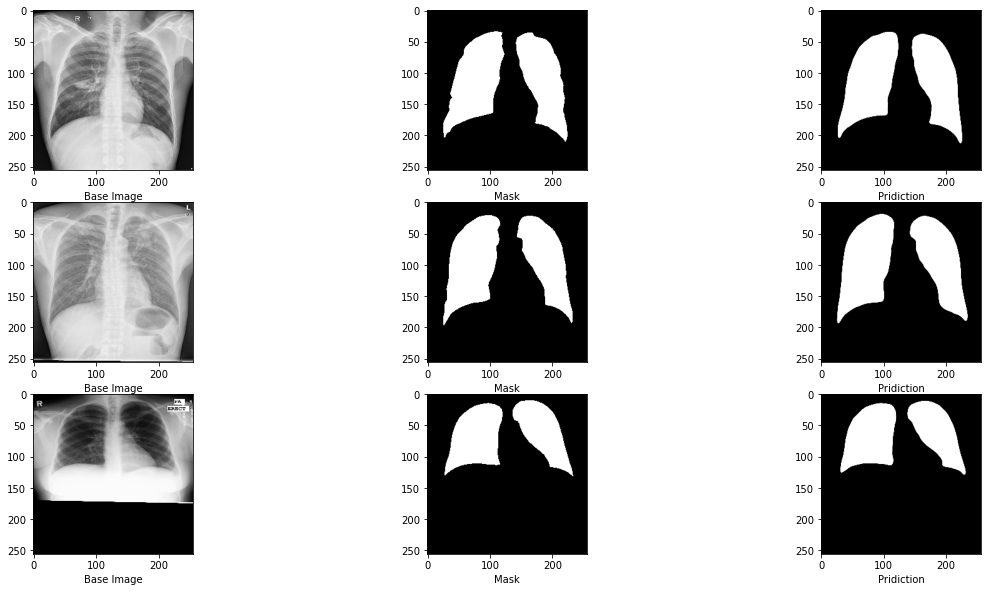

In [35]:
pred_candidates = np.random.randint(1,validation_vol.shape[0],10)

print(validation_vol.shape[0])
print(pred_candidates)
print('\n\n')

preds = model.predict(validation_vol)

print(validation_vol.shape)
print(validation_seg.shape)
print(preds.shape)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]), cmap = 'gray')
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]), cmap = 'gray')
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]), cmap = 'gray')
    plt.xlabel("Pridiction")

## Test personal lungs image (7470 lungs images)

747
[435   1 707 373 242 156 383 566 494 398]



(10, 256, 256, 1)
(10, 256, 256, 1)


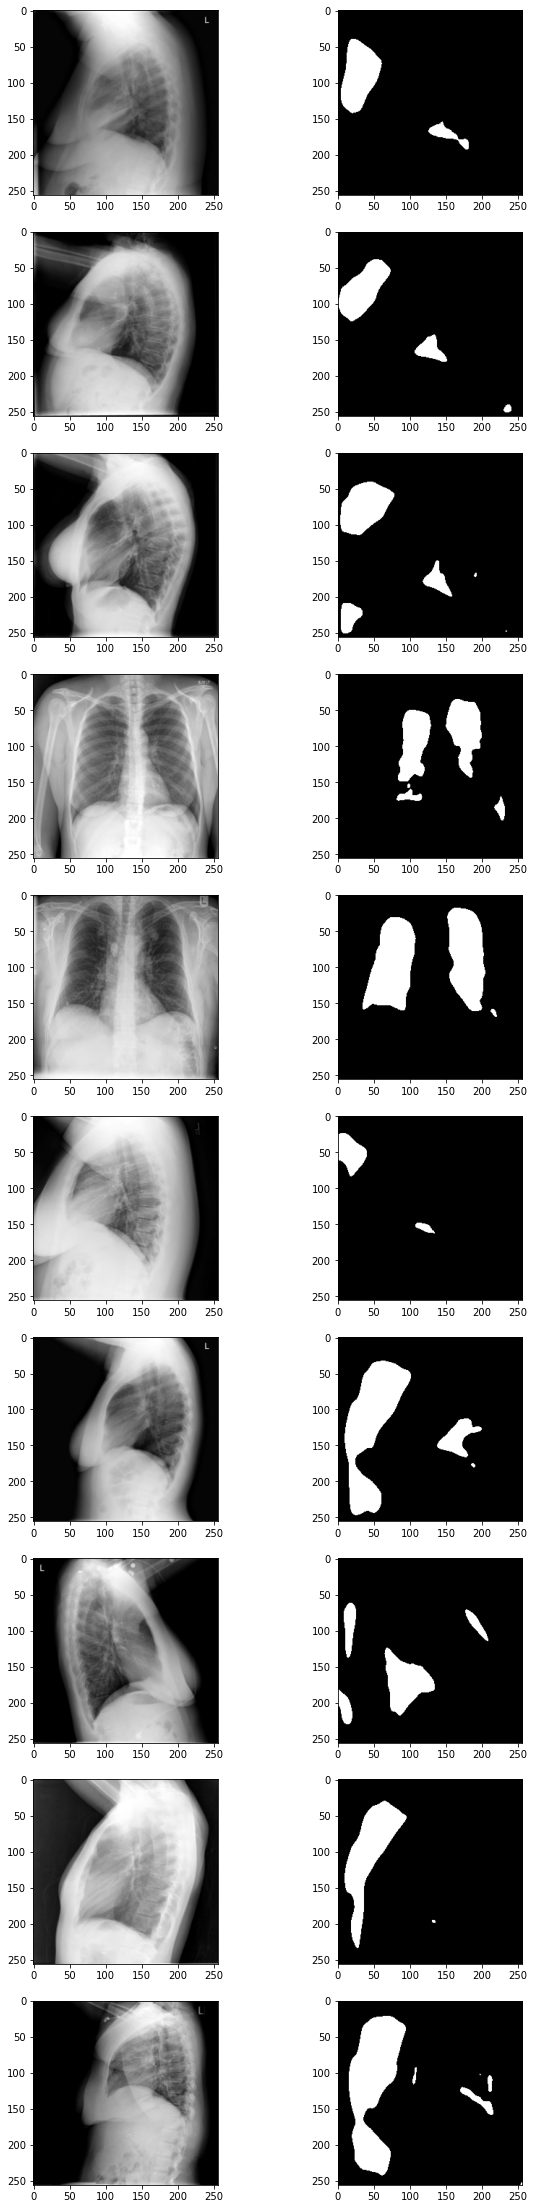

In [42]:
x_val2 = np.load('E:\ct_lung\CT_lung_segmentation-master\dataset\\x_val_7470.npy')
pred_ran = np.random.randint(1,x_val2.shape[0],10)

print(x_val2.shape[0])
print(pred_ran)
print('\n\n')

x_val3 = x_val2[pred_ran]

preds = model.predict(x_val3)

print(x_val3.shape)
print(preds.shape)

fig, ax = plt.subplots(len(x_val3), 2, figsize=(10, 40))

for i, pred in enumerate(preds):
    ax[i, 0].imshow(x_val3[i].squeeze(), cmap='gray') # CT 사진 원본
    ax[i, 1].imshow(pred.squeeze(), cmap='gray') # 만들어낸 Mask 사진 (training 결과)